# General Preparations

In [1]:
import sys
sys.path.insert(0, '/yunity/arusty/PF-GAP')

#Import libraries, MDS from SKlearn, and all the custom files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from Pipeline.functions import *


#Data
from aeon.datasets import load_gunpoint
from aeon.datasets import load_basic_motions


#Functions
from QGAP.qgap import QGAP
from Redcomets.Redcomets import REDCOMETS
from RFGAP_Rocket.RFGAP_Rocket import RFGAP_Rocket
from RDST.rdst import RDST_GAP

In [2]:
# Load Data
XTRAIN, YTRAIN = load_gunpoint(split="TRAIN")
XTEST, YTEST = load_gunpoint(split="TEST")

# XTRAIN, YTRAIN = load_basic_motions(split="TRAIN")
# XTEST, YTEST = load_basic_motions(split="TEST")

#Generate random static variables to test algorithm
XSTATIC = np.random.rand(XTRAIN.shape[0], 45)
XSTATIC_TEST = np.random.rand(XTEST.shape[0], 45)


In [3]:
#Quant
qgap = QGAP(matrix_type="dense")
quant_prox = data_to_proximities(qgap, XTRAIN, YTRAIN, XTEST, XSTATIC,XSTATIC_TEST)

#Redcomets
redcomets = REDCOMETS(variant = 3, static = XSTATIC)
redcomets_prox = data_to_proximities(redcomets, XTRAIN, YTRAIN, XTEST, None , None)

# Rocket
rf_rocket = RFGAP_Rocket(prediction_type = "classification", rocket = "Multi",
                         n_kernels=512) # Rocket Kwargs
rocket_prox = data_to_proximities(rf_rocket, XTRAIN, YTRAIN, XTEST, XSTATIC , XSTATIC_TEST)

# RDST
rdst = RDST_GAP(save_transformed_data = True)
rdst_prox = data_to_proximities(rdst, XTRAIN, YTRAIN, None, XSTATIC , None)


In [4]:
type(rocket_prox), type(rdst_prox), type(quant_prox), type(redcomets_prox)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

# Building MDS Veiwpoints

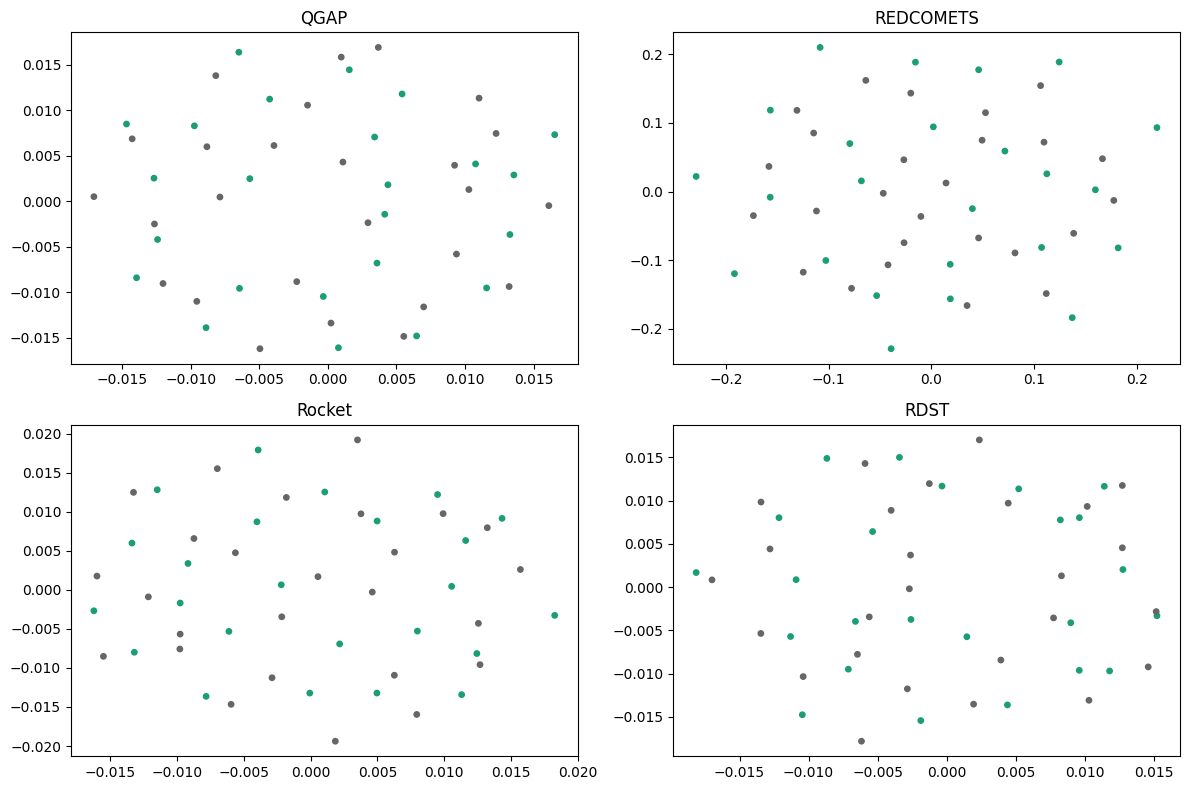

In [5]:
# Initialize MDS
def build_mds(prox):
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    symetric = (prox + prox.T) / 2
    mds_prox = mds.fit_transform(symetric)
    return mds_prox

# Build MDS for each method
mds_quant = build_mds(quant_prox)
mds_redcomets = build_mds( redcomets_prox)
mds_rocket = build_mds(rocket_prox)
mds_rdst = build_mds(rdst_prox)

# Plot the results
colors = YTRAIN.astype(int)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(mds_quant[:, 0], mds_quant[:, 1], c=colors, cmap='Dark2', marker='o', s=15)
plt.title('QGAP')
plt.subplot(2, 2, 2)
plt.scatter(mds_redcomets[:, 0], mds_redcomets[:, 1], c=colors, cmap='Dark2', marker='o', s=15)
plt.title('REDCOMETS')
plt.subplot(2, 2, 3)
plt.scatter(mds_rocket[:, 0], mds_rocket[:, 1], c=colors, cmap='Dark2', marker='o', s=15)
plt.title('Rocket')
plt.subplot(2, 2, 4)
plt.scatter(mds_rdst[:, 0], mds_rdst[:, 1], c=colors, cmap='Dark2', marker='o', s=15)
plt.title('RDST')
plt.tight_layout()


In [6]:
# Import pandas for table display
import pandas as pd

# Define a function to calculate statistics
def calculate_statistics(data):
    return {
        "Mean": round(np.mean(data), 3),
        "Std Dev": round(np.std(data), 3)
    }

# Calculate statistics for each proximity
statistics = {
    "MDS - QGAP": calculate_statistics(mds_quant),
    "MDS - REDCOMETS": calculate_statistics(mds_redcomets),
    "MDS - Rocket": calculate_statistics(mds_rocket),
    "MDS - RDST": calculate_statistics(mds_rdst),
    "Prox - QGAP": calculate_statistics(quant_prox),
    "Prox - REDCOMETS": calculate_statistics( redcomets_prox),
    "Prox - Rocket": calculate_statistics(rocket_prox),
    "Prox - RDST": calculate_statistics(rdst_prox),
}

# Convert statistics to a pandas DataFrame
statistics_df = pd.DataFrame.from_dict(statistics, orient="index")
statistics_df.index.name = "Proximity Type"
statistics_df.reset_index(inplace=True)

statistics_df


,Proximity Type,Mean,Std Dev
0,MDS - QGAP,-0.000,0.009
1,MDS - REDCOMETS,0.000,0.111
2,MDS - Rocket,-0.000,0.010
3,MDS - RDST,-0.000,0.009
4,Prox - QGAP,0.019,0.023
5,Prox - REDCOMETS,0.249,0.198
6,Prox - Rocket,0.020,0.018
7,Prox - RDST,0.020,0.022


In [9]:
# Initialize KNN classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors=3)

# Prepare a dictionary to store results
knn_results = {}

# Define a function to train and evaluate KNN
def evaluate_knn(X_train, y_train, label):
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    knn_results[label] = accuracy

# Evaluate KNN on each MDS output
evaluate_knn(mds_quant, YTRAIN.astype(int), "MDS QGAP")
evaluate_knn(mds_redcomets, YTRAIN.astype(int), "MDS REDCOMETS")
evaluate_knn(mds_rocket, YTRAIN.astype(int), "MDS Rocket")
evaluate_knn(mds_rdst, YTRAIN.astype(int), "MDS RDST")

evaluate_knn(quant_prox, YTRAIN.astype(int), "QGAP")
evaluate_knn(redcomets_prox, YTRAIN.astype(int), "REDCOMETS")
evaluate_knn(rocket_prox, YTRAIN.astype(int), "Rocket")
evaluate_knn(rdst_prox, YTRAIN.astype(int), "RDST")

# Convert results to a pandas DataFrame for display
results_df = pd.DataFrame(list(knn_results.items()), columns=["Model", "Accuracy"])
results_df

,Model,Accuracy
0,MDS QGAP,0.48
1,MDS REDCOMETS,0.58
2,MDS Rocket,0.34
3,MDS RDST,0.36
4,QGAP,1.00
5,REDCOMETS,1.00
6,Rocket,0.98
7,RDST,1.00


In [ ]:
np.mean(rf_rocket.predict(XTRAIN, XSTATIC) == YTRAIN)

np.float64(1.0)